# Youth Employment Predictive Analysis for Africa

## World Bank Indicators Analysis

This notebook performs a comprehensive analysis of youth employment indicators across African countries using World Bank data.

**Objectives:**
- Load and merge World Bank indicator datasets
- Filter for African countries
- Dynamically detect relevant socioeconomic indicators
- Perform exploratory data analysis
- Build predictive models for youth employment
- Generate policy recommendations


In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


## 1. Data Loading and Preprocessing

### 1.1 Load CSV Files with Encoding Detection


In [2]:
# Function to detect encoding
def detect_encoding(file_path):
    """Detect file encoding"""
    encodings = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']
    for enc in encodings:
        try:
            with open(file_path, 'r', encoding=enc) as f:
                f.read()
            return enc
        except:
            continue
    return 'utf-8'

# Load file1.csv
print("Loading file1.csv...")
enc1 = detect_encoding('file1.csv')
print(f"Detected encoding for file1.csv: {enc1}")

# World Bank files typically have metadata in first 4 rows
df1 = pd.read_csv('file1.csv', encoding=enc1, skiprows=4)
print(f"✅ file1.csv loaded: {df1.shape[0]} rows, {df1.shape[1]} columns")

# Load file2.csv
print("\nLoading file2.csv...")
enc2 = detect_encoding('file2.csv')
print(f"Detected encoding for file2.csv: {enc2}")

df2 = pd.read_csv('file2.csv', encoding=enc2)
print(f"✅ file2.csv loaded: {df2.shape[0]} rows, {df2.shape[1]} columns")

# Display first few rows
print("\n--- file1.csv structure ---")
print(df1.head())
print("\n--- file2.csv structure ---")
print(df2.head())


Loading file1.csv...
Detected encoding for file1.csv: utf-8
✅ file1.csv loaded: 266 rows, 70 columns

Loading file2.csv...
Detected encoding for file2.csv: utf-8
✅ file2.csv loaded: 265 rows, 6 columns

--- file1.csv structure ---
                  Country Name Country Code  \
0                        Aruba          ABW   
1  Africa Eastern and Southern          AFE   
2                  Afghanistan          AFG   
3   Africa Western and Central          AFW   
4                       Angola          AGO   

                                      Indicator Name  Indicator Code  1960  \
0  Unemployment with basic education (% of total ...  SL.UEM.BASC.ZS   NaN   
1  Unemployment with basic education (% of total ...  SL.UEM.BASC.ZS   NaN   
2  Unemployment with basic education (% of total ...  SL.UEM.BASC.ZS   NaN   
3  Unemployment with basic education (% of total ...  SL.UEM.BASC.ZS   NaN   
4  Unemployment with basic education (% of total ...  SL.UEM.BASC.ZS   NaN   

   1961  1962  19

### 1.2 Clean Column Names and Inspect Structure


In [3]:
# Clean column names (remove quotes, spaces, etc.)
df1.columns = df1.columns.str.strip().str.replace('"', '').str.strip()
df2.columns = df2.columns.str.strip().str.replace('"', '').str.strip()

# Display column names
print("file1.csv columns:")
print(df1.columns.tolist())
print("\nfile2.csv columns:")
print(df2.columns.tolist())

# Check for common merge columns
print("\n--- Checking for merge columns ---")
common_cols = set(df1.columns) & set(df2.columns)
print(f"Common columns: {common_cols}")

# Identify key columns dynamically
country_col1 = None
country_col2 = None
code_col1 = None
code_col2 = None

for col in df1.columns:
    if 'country' in col.lower() and 'name' in col.lower():
        country_col1 = col
    if 'country' in col.lower() and 'code' in col.lower():
        code_col1 = col

for col in df2.columns:
    if 'country' in col.lower() and 'name' in col.lower():
        country_col2 = col
    if 'country' in col.lower() and 'code' in col.lower():
        code_col2 = col

print(f"\nDetected columns:")
print(f"  file1 - Country Name: {country_col1}, Country Code: {code_col1}")
print(f"  file2 - Country Name: {country_col2}, Country Code: {code_col2}")

file1.csv columns:
['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', 'Unnamed: 69']

file2.csv columns:
['Country Code', 'Region', 'IncomeGroup', 'SpecialNotes', 'TableName', 'Unnamed: 5']

--- Checking for merge columns ---
Common columns: {'Country Code'}

Detected columns:
  file1 - Country Name: Country Name, Country Code: Country Code
  file2 - Country Name: None, Country Code: Country Code


### 1.3 Melt Pivoted World Bank Format (if necessary)

In [4]:
# Check if file1 is in pivoted format (years as columns)
year_cols = [col for col in df1.columns if col.isdigit() and len(col) == 4]
print(f"Found {len(year_cols)} year columns in file1.csv")

if len(year_cols) > 0:
    print("⚠️  Detected pivoted format - melting to long format...")
    
    # Identify ID columns (non-year columns)
    id_cols = [col for col in df1.columns if col not in year_cols]
    print(f"ID columns: {id_cols}")
    
    # Melt the dataframe
    df1_melted = pd.melt(
        df1,
        id_vars=id_cols,
        value_vars=year_cols,
        var_name='Year',
        value_name='Value'
    )
    
    # Convert Year to numeric
    df1_melted['Year'] = pd.to_numeric(df1_melted['Year'], errors='coerce')
    
    # Convert Value to numeric
    df1_melted['Value'] = pd.to_numeric(df1_melted['Value'], errors='coerce')
    
    print(f"✅ Melted dataframe: {df1_melted.shape[0]} rows, {df1_melted.shape[1]} columns")
    print(df1_melted.head())
else:
    print("✅ Data is already in long format")
    df1_melted = df1.copy()


Found 65 year columns in file1.csv
⚠️  Detected pivoted format - melting to long format...
ID columns: ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 69']
✅ Melted dataframe: 17290 rows, 7 columns
                  Country Name Country Code  \
0                        Aruba          ABW   
1  Africa Eastern and Southern          AFE   
2                  Afghanistan          AFG   
3   Africa Western and Central          AFW   
4                       Angola          AGO   

                                      Indicator Name  Indicator Code  \
0  Unemployment with basic education (% of total ...  SL.UEM.BASC.ZS   
1  Unemployment with basic education (% of total ...  SL.UEM.BASC.ZS   
2  Unemployment with basic education (% of total ...  SL.UEM.BASC.ZS   
3  Unemployment with basic education (% of total ...  SL.UEM.BASC.ZS   
4  Unemployment with basic education (% of total ...  SL.UEM.BASC.ZS   

   Unnamed: 69  Year  Value  
0          NaN  1960    N

### 1.4 Merge Both Files


In [5]:
# Merge on Country Code (most reliable)
merge_col = code_col1 if code_col1 else 'Country Code'
print(f"Merging on: {merge_col}")

# Merge the dataframes
df_merged = df1_melted.merge(
    df2,
    on=merge_col,
    how='left',
    suffixes=('', '_metadata')
)

print(f"✅ Merged dataframe: {df_merged.shape[0]} rows, {df_merged.shape[1]} columns")
print(f"\nMerged columns: {df_merged.columns.tolist()}")
print(f"\nFirst few rows:")
print(df_merged.head())


Merging on: Country Code
✅ Merged dataframe: 17290 rows, 12 columns

Merged columns: ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 69', 'Year', 'Value', 'Region', 'IncomeGroup', 'SpecialNotes', 'TableName', 'Unnamed: 5']

First few rows:
                  Country Name Country Code  \
0                        Aruba          ABW   
1  Africa Eastern and Southern          AFE   
2                  Afghanistan          AFG   
3   Africa Western and Central          AFW   
4                       Angola          AGO   

                                      Indicator Name  Indicator Code  \
0  Unemployment with basic education (% of total ...  SL.UEM.BASC.ZS   
1  Unemployment with basic education (% of total ...  SL.UEM.BASC.ZS   
2  Unemployment with basic education (% of total ...  SL.UEM.BASC.ZS   
3  Unemployment with basic education (% of total ...  SL.UEM.BASC.ZS   
4  Unemployment with basic education (% of total ...  SL.UEM.BASC.ZS   

   Unnamed: 6

## 2. Filter for African Countries


In [6]:
# Complete list of African countries (including the remaining 6)
african_countries = [
    "Sierra Leone", "Nigeria", "Ghana", "Kenya", "South Africa", "Uganda",
    "Egypt", "Senegal", "Morocco", "Algeria", "Angola", "Zimbabwe", "Zambia",
    "Cameroon", "Tanzania", "Rwanda", "Burkina Faso", "Mali", "Botswana",
    "Namibia", "Ethiopia", "Benin", "Togo", "Guinea", "Liberia", "Gambia",
    "Chad", "Niger", "Sudan", "South Sudan", "Somalia", "Congo", "DR Congo",
    "Tunisia", "Libya", "Eritrea", "Djibouti", "Mauritania", "Cape Verde",
    "Lesotho", "Eswatini", "Madagascar", "Malawi", "Mozambique",
    "Central African Republic",
    # Additional 6 African countries
    "Mauritius", "Gabon", "Equatorial Guinea", "Guinea-Bissau", "Comoros", "Sao Tome and Principe"
]

print(f"Total African countries in list: {len(african_countries)}")

# Get the country name column
country_name_col = country_col1 if country_col1 else 'Country Name'

# Filter for African countries
df_africa = df_merged[df_merged[country_name_col].isin(african_countries)].copy()

print(f"\n✅ Filtered to African countries: {df_africa.shape[0]} rows")
print(f"Unique African countries found: {df_africa[country_name_col].nunique()}")
print(f"\nAfrican countries in dataset:")
print(sorted(df_africa[country_name_col].unique()))


Total African countries in list: 51

✅ Filtered to African countries: 2925 rows
Unique African countries found: 45

African countries in dataset:
['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Djibouti', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Gabon', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'Sao Tome and Principe', 'Senegal', 'Sierra Leone', 'South Africa', 'South Sudan', 'Sudan', 'Tanzania', 'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe']


## 3. Identify Available Indicators


In [7]:
# Get all unique indicators
indicator_col = 'Indicator Name' if 'Indicator Name' in df_africa.columns else 'Indicator Name'
all_indicators = df_africa[indicator_col].unique()

print(f"Total unique indicators: {len(all_indicators)}")
print("\nAll available indicators:")
for idx, ind in enumerate(all_indicators, 1):
    print(f"{idx}. {ind}")

# Search for target indicators
print("\n" + "="*80)
print("SEARCHING FOR RELEVANT INDICATORS")
print("="*80)

# Youth unemployment
youth_unemp_keywords = ['youth', 'unemployment', 'young', '15-24', '15 to 24']
youth_unemp_indicator = None
for ind in all_indicators:
    if any(kw.lower() in str(ind).lower() for kw in youth_unemp_keywords):
        youth_unemp_indicator = ind
        print(f"\n✅ Found YOUTH UNEMPLOYMENT indicator: {ind}")
        break

if not youth_unemp_indicator:
    # Fallback: look for any unemployment indicator
    for ind in all_indicators:
        if 'unemployment' in str(ind).lower():
            youth_unemp_indicator = ind
            print(f"\n⚠️  Using general UNEMPLOYMENT indicator (youth-specific not found): {ind}")
            break

# Education indicators
education_keywords = ['education', 'school', 'literacy', 'enrollment', 'primary', 'secondary', 'tertiary']
education_indicators = []
for ind in all_indicators:
    if any(kw.lower() in str(ind).lower() for kw in education_keywords):
        education_indicators.append(ind)

if education_indicators:
    print(f"\n✅ Found {len(education_indicators)} EDUCATION-related indicators:")
    for ind in education_indicators[:5]:  # Show first 5
        print(f"   - {ind}")
    best_education = education_indicators[0]  # Use first one
else:
    print("\n⚠️  No education indicators found - will use alternative socioeconomic features")
    best_education = None

# GDP indicators
gdp_keywords = ['gdp', 'gross domestic product', 'income', 'gnp']
gdp_indicator = None
for ind in all_indicators:
    if any(kw.lower() in str(ind).lower() for kw in gdp_keywords):
        gdp_indicator = ind
        print(f"\n✅ Found GDP/INCOME indicator: {ind}")
        break

# Internet/ICT indicators
internet_keywords = ['internet', 'ict', 'mobile', 'telephone', 'broadband', 'technology']
internet_indicators = []
for ind in all_indicators:
    if any(kw.lower() in str(ind).lower() for kw in internet_keywords):
        internet_indicators.append(ind)

if internet_indicators:
    print(f"\n✅ Found {len(internet_indicators)} INTERNET/ICT-related indicators:")
    for ind in internet_indicators[:3]:
        print(f"   - {ind}")
    best_internet = internet_indicators[0]
else:
    print("\n⚠️  No internet/ICT indicators found - will use alternative features")
    best_internet = None

# Store selected indicators
selected_indicators = {
    'youth_unemployment': youth_unemp_indicator,
    'education': best_education,
    'gdp': gdp_indicator,
    'internet': best_internet
}

print("\n" + "="*80)
print("SELECTED INDICATORS SUMMARY")
print("="*80)
for key, value in selected_indicators.items():
    status = "✅" if value else "❌"
    print(f"{status} {key.upper()}: {value}")


Total unique indicators: 1

All available indicators:
1. Unemployment with basic education (% of total labor force with basic education)

SEARCHING FOR RELEVANT INDICATORS

✅ Found YOUTH UNEMPLOYMENT indicator: Unemployment with basic education (% of total labor force with basic education)

✅ Found 1 EDUCATION-related indicators:
   - Unemployment with basic education (% of total labor force with basic education)

⚠️  No internet/ICT indicators found - will use alternative features

SELECTED INDICATORS SUMMARY
✅ YOUTH_UNEMPLOYMENT: Unemployment with basic education (% of total labor force with basic education)
✅ EDUCATION: Unemployment with basic education (% of total labor force with basic education)
❌ GDP: None
❌ INTERNET: None


## 4. Data Cleaning


In [8]:
# Show summary before cleaning
print("BEFORE CLEANING:")
print(f"Total rows: {len(df_africa)}")
print(f"Missing values per column:")
print(df_africa.isnull().sum().sort_values(ascending=False).head(10))

# Filter for selected indicators only
if youth_unemp_indicator:
    df_analysis = df_africa[df_africa[indicator_col] == youth_unemp_indicator].copy()
    print(f"\n✅ Filtered to youth unemployment indicator: {len(df_analysis)} rows")
else:
    # If no youth unemployment, use all unemployment data
    df_analysis = df_africa[df_africa[indicator_col].str.contains('unemployment', case=False, na=False)].copy()
    print(f"\n⚠️  Using all unemployment data: {len(df_analysis)} rows")

# Remove rows with missing values in key columns
print("\nCleaning data...")
initial_rows = len(df_analysis)

# Remove missing values in Value column
df_analysis = df_analysis.dropna(subset=['Value'])
print(f"Removed {initial_rows - len(df_analysis)} rows with missing values")

# Convert Year to numeric (if not already)
df_analysis['Year'] = pd.to_numeric(df_analysis['Year'], errors='coerce')
df_analysis = df_analysis.dropna(subset=['Year'])

# Convert Value to numeric (if not already)
df_analysis['Value'] = pd.to_numeric(df_analysis['Value'], errors='coerce')
df_analysis = df_analysis.dropna(subset=['Value'])

# Remove duplicates
before_dedup = len(df_analysis)
df_analysis = df_analysis.drop_duplicates()
print(f"Removed {before_dedup - len(df_analysis)} duplicate rows")

# Filter to recent years (2000 onwards for better data quality)
df_analysis = df_analysis[df_analysis['Year'] >= 2000].copy()

print(f"\n✅ AFTER CLEANING:")
print(f"Total rows: {len(df_analysis)}")
print(f"Countries: {df_analysis[country_name_col].nunique()}")
print(f"Year range: {df_analysis['Year'].min()} - {df_analysis['Year'].max()}")
print(f"\nMissing values:")
print(df_analysis.isnull().sum().sort_values(ascending=False).head())

print(f"\nFirst few rows of cleaned data:")
print(df_analysis.head())


BEFORE CLEANING:
Total rows: 2925
Missing values per column:
Unnamed: 5        2925
Unnamed: 69       2925
Value             2677
SpecialNotes      1755
IncomeGroup         65
Indicator Name       0
Country Code         0
Country Name         0
Indicator Code       0
Year                 0
dtype: int64

✅ Filtered to youth unemployment indicator: 2925 rows

Cleaning data...
Removed 2677 rows with missing values
Removed 0 duplicate rows

✅ AFTER CLEANING:
Total rows: 239
Countries: 40
Year range: 2000 - 2024

Missing values:
Unnamed: 5        239
Unnamed: 69       239
SpecialNotes      144
IncomeGroup         3
Indicator Code      0
dtype: int64

First few rows of cleaned data:
       Country Name Country Code  \
10723         Ghana          GHA   
10903  South Africa          ZAF   
11057    Madagascar          MDG   
11073     Mauritius          MUS   
11152      Tanzania          TZA   

                                          Indicator Name  Indicator Code  \
10723  Unemployment w

### 4.1 Create Pivot Table for Multiple Indicators


In [9]:
# Create a comprehensive dataset with all relevant indicators
# First, get all indicators for African countries
indicators_to_include = []

# Add youth unemployment
if youth_unemp_indicator:
    indicators_to_include.append(youth_unemp_indicator)

# Add education
if best_education:
    indicators_to_include.append(best_education)

# Add GDP
if gdp_indicator:
    indicators_to_include.append(gdp_indicator)

# Add internet
if best_internet:
    indicators_to_include.append(best_internet)

# If we don't have enough indicators, include all available
if len(indicators_to_include) < 3:
    print("⚠️  Limited indicators found. Including all available indicators for analysis...")
    indicators_to_include = list(all_indicators[:10])  # Use first 10 indicators

print(f"\nIncluding {len(indicators_to_include)} indicators in analysis:")
for ind in indicators_to_include:
    print(f"  - {ind}")

# Filter for these indicators
df_all_indicators = df_africa[df_africa[indicator_col].isin(indicators_to_include)].copy()

# Clean this dataset too
df_all_indicators = df_all_indicators.dropna(subset=['Value', 'Year'])
df_all_indicators['Year'] = pd.to_numeric(df_all_indicators['Year'], errors='coerce')
df_all_indicators['Value'] = pd.to_numeric(df_all_indicators['Value'], errors='coerce')
df_all_indicators = df_all_indicators.dropna(subset=['Value', 'Year'])
df_all_indicators = df_all_indicators[df_all_indicators['Year'] >= 2000]

# Create pivot table: Country x Year x Indicator
# We'll pivot to have indicators as columns
df_pivot = df_all_indicators.pivot_table(
    index=[country_name_col, 'Year'],
    columns=indicator_col,
    values='Value',
    aggfunc='mean'
).reset_index()

print(f"\n✅ Pivot table created: {df_pivot.shape[0]} rows, {df_pivot.shape[1]} columns")
print(f"Columns: {df_pivot.columns.tolist()}")
print(f"\nFirst few rows:")
print(df_pivot.head())


⚠️  Limited indicators found. Including all available indicators for analysis...

Including 1 indicators in analysis:
  - Unemployment with basic education (% of total labor force with basic education)

✅ Pivot table created: 239 rows, 3 columns
Columns: ['Country Name', 'Year', 'Unemployment with basic education (% of total labor force with basic education)']

First few rows:
Indicator Name Country Name  Year  \
0                   Algeria  2004   
1                    Angola  2004   
2                    Angola  2009   
3                    Angola  2011   
4                    Angola  2014   

Indicator Name  Unemployment with basic education (% of total labor force with basic education)  
0                                                          23.620                                
1                                                          31.376                                
2                                                           6.696                                
3    

## 5. Exploratory Data Analysis (EDA)


In [10]:
# Prepare data for EDA
# Use the pivot table and merge with main unemployment data
df_eda = df_analysis.copy()

# If we have pivot table with multiple indicators, merge it
if len(df_pivot) > 0:
    # Merge pivot data
    merge_cols = [country_name_col, 'Year']
    df_eda = df_eda.merge(
        df_pivot,
        on=merge_cols,
        how='left',
        suffixes=('', '_pivot')
    )

print("✅ EDA dataset prepared")
print(f"Shape: {df_eda.shape}")
print(f"Columns: {df_eda.columns.tolist()}")


✅ EDA dataset prepared
Shape: (239, 13)
Columns: ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 69', 'Year', 'Value', 'Region', 'IncomeGroup', 'SpecialNotes', 'TableName', 'Unnamed: 5', 'Unemployment with basic education (% of total labor force with basic education)']


### 5.1 Youth Unemployment vs Education Indicator


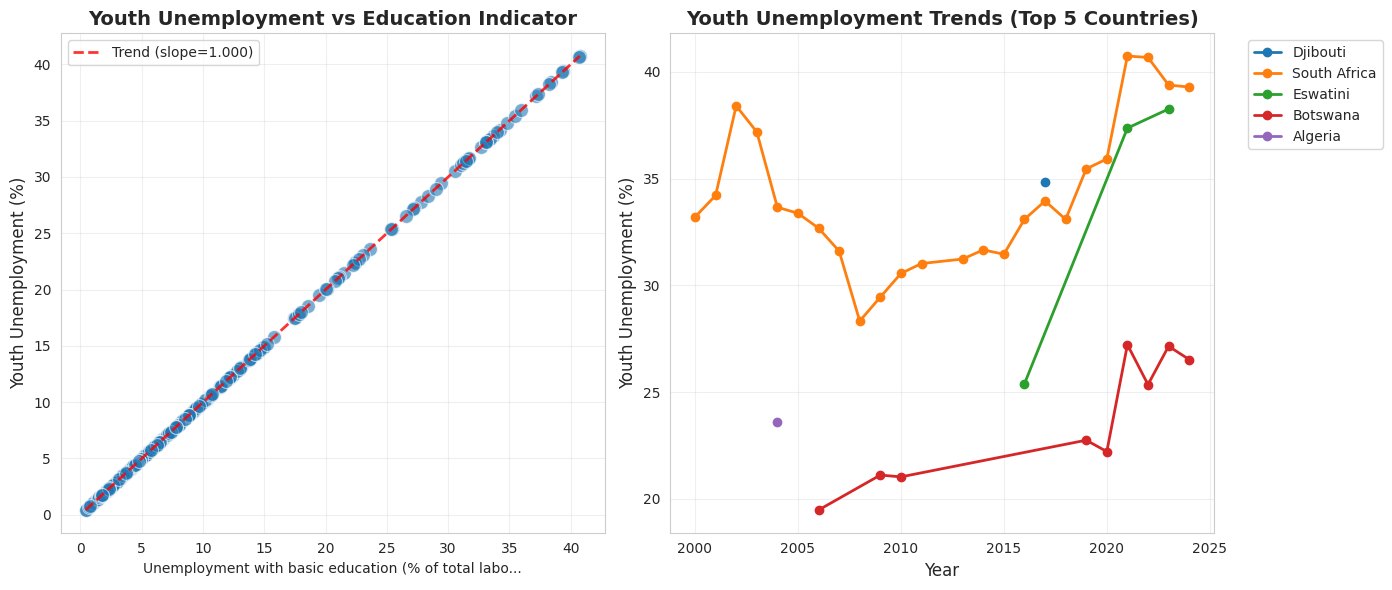


📊 Correlation between Youth Unemployment and Unemployment with basic education (% of : 1.000


In [11]:
# Find education column in pivot
education_col = None
if best_education and best_education in df_eda.columns:
    education_col = best_education
else:
    # Find any column with education-related keywords
    for col in df_eda.columns:
        if any(kw in str(col).lower() for kw in ['education', 'school', 'literacy', 'enrollment']):
            education_col = col
            break

if education_col:
    # Create plot data
    plot_data = df_eda[[country_name_col, 'Year', 'Value', education_col]].dropna()
    
    if len(plot_data) > 0:
        plt.figure(figsize=(14, 6))
        
        # Scatter plot
        plt.subplot(1, 2, 1)
        sns.scatterplot(data=plot_data, x=education_col, y='Value', alpha=0.6, s=100)
        plt.xlabel(f'{education_col[:50]}...' if len(education_col) > 50 else education_col, fontsize=10)
        plt.ylabel('Youth Unemployment (%)', fontsize=12)
        plt.title('Youth Unemployment vs Education Indicator', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        
        # Add trend line
        z = np.polyfit(plot_data[education_col], plot_data['Value'], 1)
        p = np.poly1d(z)
        plt.plot(plot_data[education_col].sort_values(), p(plot_data[education_col].sort_values()), 
                "r--", alpha=0.8, linewidth=2, label=f'Trend (slope={z[0]:.3f})')
        plt.legend()
        
        # Time series by country (top 5 countries)
        plt.subplot(1, 2, 2)
        top_countries = plot_data.groupby(country_name_col)['Value'].mean().nlargest(5).index
        for country in top_countries:
            country_data = plot_data[plot_data[country_name_col] == country].sort_values('Year')
            plt.plot(country_data['Year'], country_data['Value'], marker='o', label=country, linewidth=2)
        
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('Youth Unemployment (%)', fontsize=12)
        plt.title('Youth Unemployment Trends (Top 5 Countries)', fontsize=14, fontweight='bold')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Correlation
        corr = plot_data['Value'].corr(plot_data[education_col])
        print(f"\n📊 Correlation between Youth Unemployment and {education_col[:40]}: {corr:.3f}")
    else:
        print("⚠️  No overlapping data for education indicator")
else:
    print("⚠️  Education indicator not available in merged data")


### 5.2 Youth Unemployment vs Internet/ICT Indicator


In [12]:
# Find internet column in pivot
internet_col = None
if best_internet and best_internet in df_eda.columns:
    internet_col = best_internet
else:
    # Find any column with internet-related keywords
    for col in df_eda.columns:
        if any(kw in str(col).lower() for kw in ['internet', 'ict', 'mobile', 'telephone', 'technology']):
            internet_col = col
            break

if internet_col:
    # Create plot data
    plot_data = df_eda[[country_name_col, 'Year', 'Value', internet_col]].dropna()
    
    if len(plot_data) > 0:
        plt.figure(figsize=(14, 6))
        
        # Scatter plot
        plt.subplot(1, 2, 1)
        sns.scatterplot(data=plot_data, x=internet_col, y='Value', alpha=0.6, s=100, color='green')
        plt.xlabel(f'{internet_col[:50]}...' if len(internet_col) > 50 else internet_col, fontsize=10)
        plt.ylabel('Youth Unemployment (%)', fontsize=12)
        plt.title('Youth Unemployment vs Internet/ICT Indicator', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        
        # Add trend line
        z = np.polyfit(plot_data[internet_col], plot_data['Value'], 1)
        p = np.poly1d(z)
        plt.plot(plot_data[internet_col].sort_values(), p(plot_data[internet_col].sort_values()), 
                "r--", alpha=0.8, linewidth=2, label=f'Trend (slope={z[0]:.3f})')
        plt.legend()
        
        # Box plot by year
        plt.subplot(1, 2, 2)
        plot_data['Year_str'] = plot_data['Year'].astype(str)
        sns.boxplot(data=plot_data, x='Year_str', y='Value')
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('Youth Unemployment (%)', fontsize=12)
        plt.title('Youth Unemployment Distribution by Year', fontsize=14, fontweight='bold')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Correlation
        corr = plot_data['Value'].corr(plot_data[internet_col])
        print(f"\n📊 Correlation between Youth Unemployment and {internet_col[:40]}: {corr:.3f}")
    else:
        print("⚠️  No overlapping data for internet indicator")
else:
    print("⚠️  Internet/ICT indicator not available in merged data")


⚠️  Internet/ICT indicator not available in merged data


### 5.3 Correlation Heatmap


Numeric columns for correlation: 4


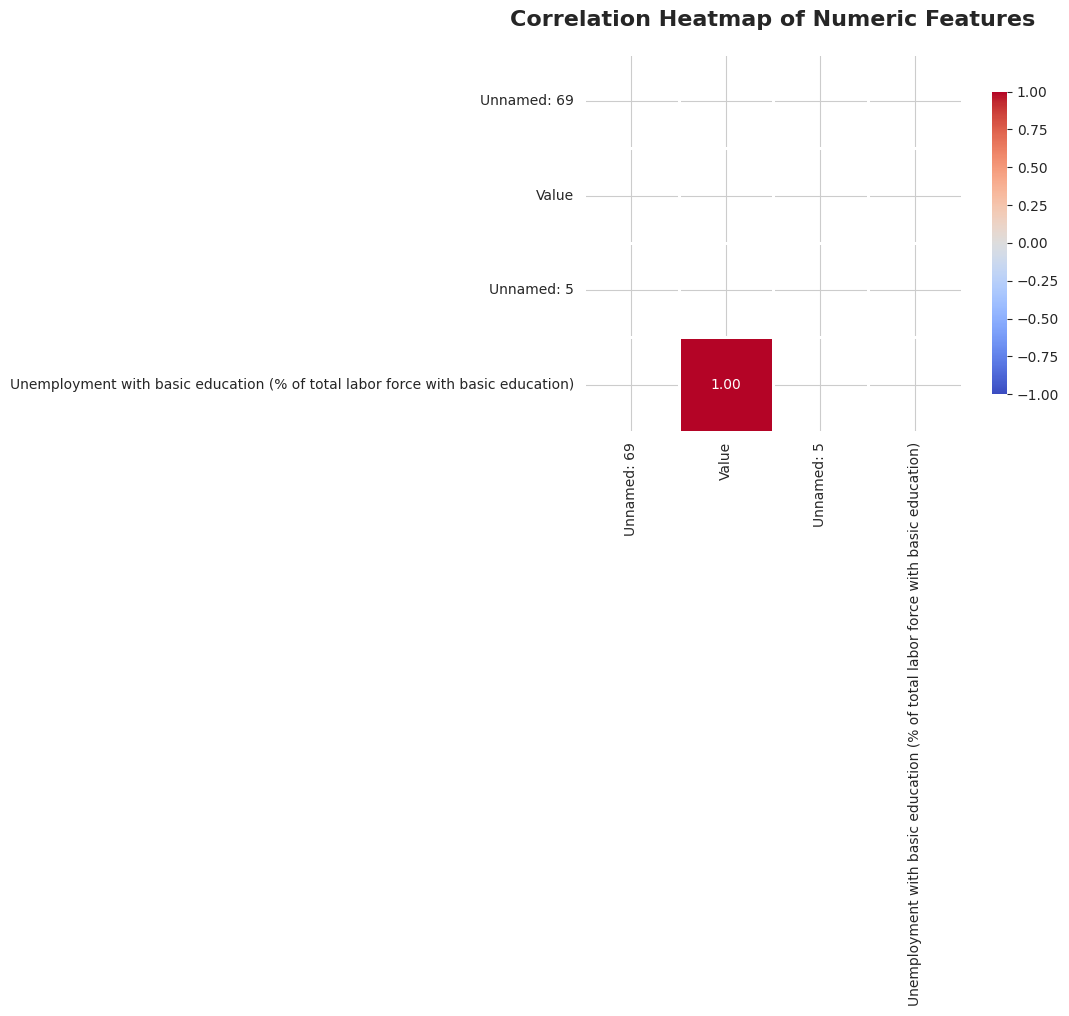


📊 Top 10 Correlations with Youth Unemployment:
 1. Unemployment with basic education (% of total labor for ↑   1.000
 2. Unnamed: 69                                             ↓     nan
 3. Unnamed: 5                                              ↓     nan


In [13]:
# Select only numeric columns for correlation
numeric_cols = df_eda.select_dtypes(include=[np.number]).columns.tolist()
# Remove Year as it's not a feature
if 'Year' in numeric_cols:
    numeric_cols.remove('Year')

print(f"Numeric columns for correlation: {len(numeric_cols)}")

if len(numeric_cols) > 1:
    # Calculate correlation matrix
    corr_matrix = df_eda[numeric_cols].corr()
    
    # Plot heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
    sns.heatmap(
        corr_matrix,
        mask=mask,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        center=0,
        square=True,
        linewidths=1,
        cbar_kws={"shrink": 0.8},
        vmin=-1,
        vmax=1
    )
    plt.title('Correlation Heatmap of Numeric Features', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    # Top correlations with youth unemployment (Value column)
    if 'Value' in corr_matrix.columns:
        target_corr = corr_matrix['Value'].drop('Value').sort_values(ascending=False, key=abs)
        print("\n📊 Top 10 Correlations with Youth Unemployment:")
        print("="*60)
        for idx, (feature, corr_val) in enumerate(target_corr.head(10).items(), 1):
            direction = "↑" if corr_val > 0 else "↓"
            print(f"{idx:2d}. {feature[:55]:55s} {direction} {corr_val:7.3f}")
else:
    print("⚠️  Not enough numeric columns for correlation analysis")


## 6. Predictive Modeling


In [14]:
# Prepare data for modeling
# Use the pivot table with all indicators
df_model = df_pivot.copy()

# Identify target variable (youth unemployment)
target_col = None
if youth_unemp_indicator and youth_unemp_indicator in df_model.columns:
    target_col = youth_unemp_indicator
else:
    # Find any unemployment column
    for col in df_model.columns:
        if 'unemployment' in str(col).lower():
            target_col = col
            break

if target_col is None:
    print("⚠️  No target variable found. Using Value from main dataset...")
    # Fallback: use the main analysis dataset
    df_model = df_eda.copy()
    target_col = 'Value'

print(f"Target variable: {target_col}")

# Select features (all numeric columns except target and metadata)
feature_cols = [col for col in df_model.select_dtypes(include=[np.number]).columns 
                if col not in [target_col, 'Year'] and not col.startswith('Unnamed')]

# Remove columns with too many missing values (>50%)
feature_cols = [col for col in feature_cols 
                if df_model[col].notna().sum() / len(df_model) > 0.5]

print(f"\nSelected {len(feature_cols)} features:")
for col in feature_cols:
    print(f"  - {col[:60]}")

# Prepare X and y
X = df_model[feature_cols].copy()
y = df_model[target_col].copy()

# Remove rows with missing target
valid_idx = y.notna()
X = X[valid_idx]
y = y[valid_idx]

# Fill remaining missing values in features with median
X = X.fillna(X.median())

# Remove rows where all features are missing
X = X.dropna(how='all')
y = y.loc[X.index]

print(f"\n✅ Model dataset prepared:")
print(f"   Samples: {len(X)}")
print(f"   Features: {len(X.columns)}")
print(f"   Target range: {y.min():.2f} - {y.max():.2f}")
print(f"   Target mean: {y.mean():.2f}")

if len(X) == 0 or len(X.columns) == 0:
    print("\n❌ ERROR: No valid data for modeling!")
    print("Using alternative approach with available data...")
    # Use simpler approach with just the main dataset
    df_model = df_analysis.copy()
    # Create some derived features
    df_model['Year_squared'] = df_model['Year'] ** 2
    df_model['Year_normalized'] = (df_model['Year'] - df_model['Year'].min()) / (df_model['Year'].max() - df_model['Year'].min())
    
    # Group by country for country-level features
    country_stats = df_model.groupby(country_name_col)['Value'].agg(['mean', 'std', 'min', 'max']).reset_index()
    country_stats.columns = [country_name_col, 'country_mean', 'country_std', 'country_min', 'country_max']
    df_model = df_model.merge(country_stats, on=country_name_col, how='left')
    
    X = df_model[['Year', 'Year_squared', 'Year_normalized', 'country_mean', 'country_std']].fillna(0)
    y = df_model['Value']
    feature_cols = X.columns.tolist()
    print(f"\n✅ Alternative model dataset:")
    print(f"   Samples: {len(X)}")
    print(f"   Features: {feature_cols}")


Target variable: Unemployment with basic education (% of total labor force with basic education)

Selected 0 features:

✅ Model dataset prepared:
   Samples: 0
   Features: 0
   Target range: nan - nan
   Target mean: nan

❌ ERROR: No valid data for modeling!
Using alternative approach with available data...

✅ Alternative model dataset:
   Samples: 239
   Features: ['Year', 'Year_squared', 'Year_normalized', 'country_mean', 'country_std']


### 6.1 Train-Test Split


In [15]:
# Train-test split
if len(X) > 10:  # Need at least 10 samples
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print(f"✅ Train-test split completed:")
    print(f"   Training samples: {len(X_train)}")
    print(f"   Test samples: {len(X_test)}")
else:
    # If too few samples, use all for training
    print("⚠️  Too few samples for train-test split. Using all data for training.")
    X_train, X_test = X, X
    y_train, y_test = y, y


✅ Train-test split completed:
   Training samples: 191
   Test samples: 48


### 6.2 Linear Regression Model


LINEAR REGRESSION RESULTS
Training R² Score: 0.9097
Test R² Score:     0.8985
Training RMSE:     2.9300
Test RMSE:         3.9978


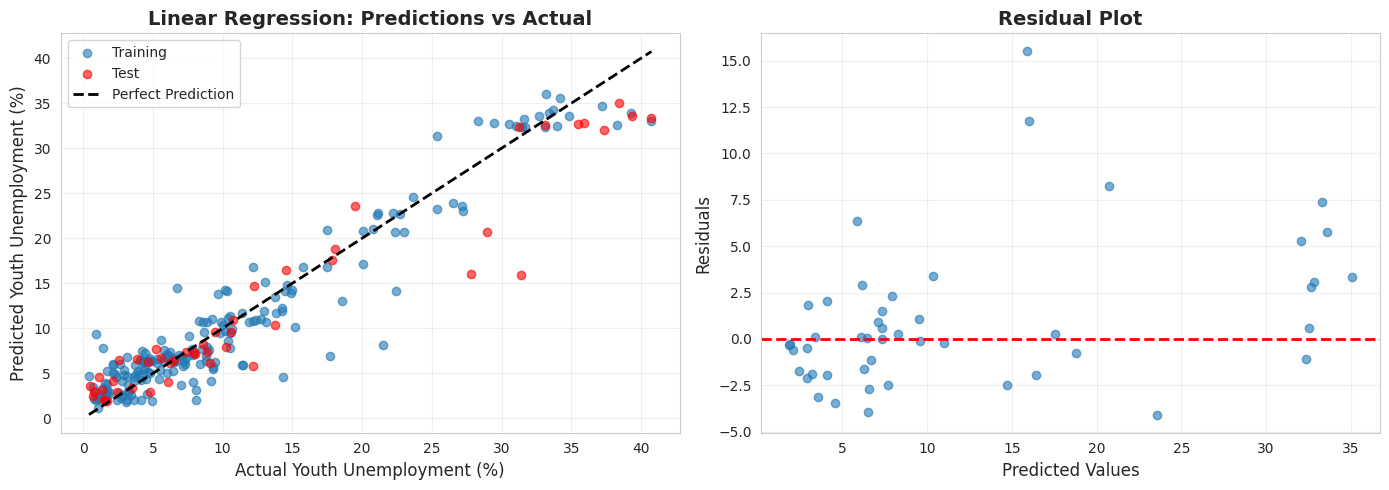

In [16]:
# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

# Metrics
train_r2_lr = r2_score(y_train, y_train_pred_lr)
test_r2_lr = r2_score(y_test, y_test_pred_lr)
train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))

print("="*60)
print("LINEAR REGRESSION RESULTS")
print("="*60)
print(f"Training R² Score: {train_r2_lr:.4f}")
print(f"Test R² Score:     {test_r2_lr:.4f}")
print(f"Training RMSE:     {train_rmse_lr:.4f}")
print(f"Test RMSE:         {test_rmse_lr:.4f}")

# Plot predictions vs actual
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred_lr, alpha=0.6, label='Training')
plt.scatter(y_test, y_test_pred_lr, alpha=0.6, label='Test', color='red')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Youth Unemployment (%)', fontsize=12)
plt.ylabel('Predicted Youth Unemployment (%)', fontsize=12)
plt.title('Linear Regression: Predictions vs Actual', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
residuals = y_test - y_test_pred_lr
plt.scatter(y_test_pred_lr, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residual Plot', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 6.3 Random Forest Regressor Model


RANDOM FOREST REGRESSOR RESULTS
Training R² Score: 0.9805
Test R² Score:     0.8967
Training RMSE:     1.3609
Test RMSE:         4.0323

FEATURE IMPORTANCE (Random Forest)
country_mean                                             0.9229
country_std                                              0.0203
Year                                                     0.0195
Year_squared                                             0.0188
Year_normalized                                          0.0185


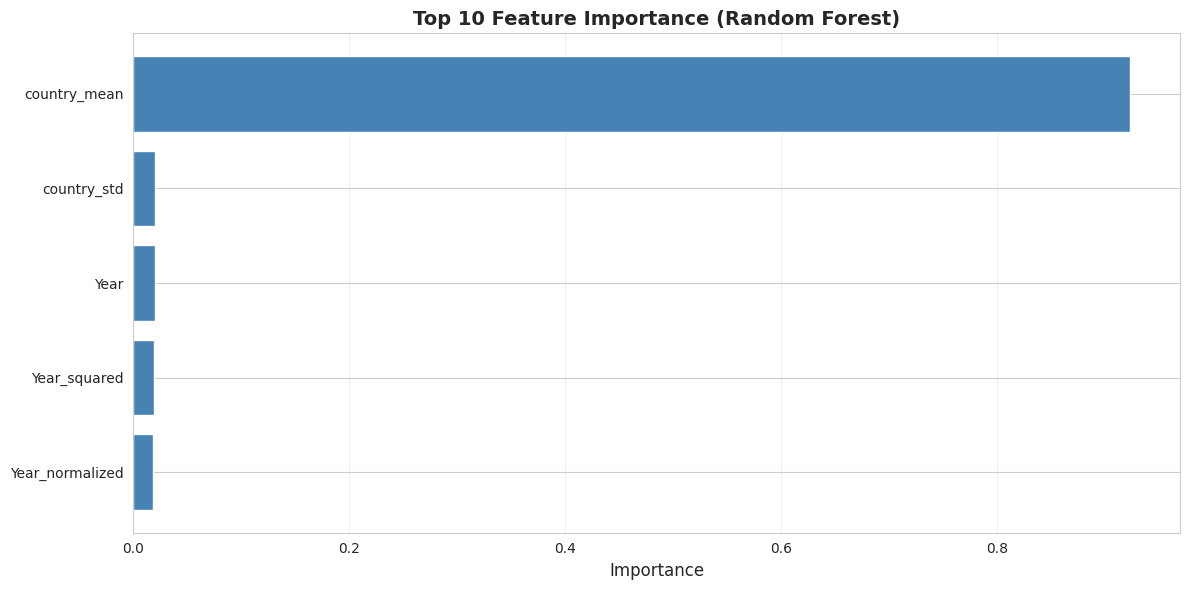

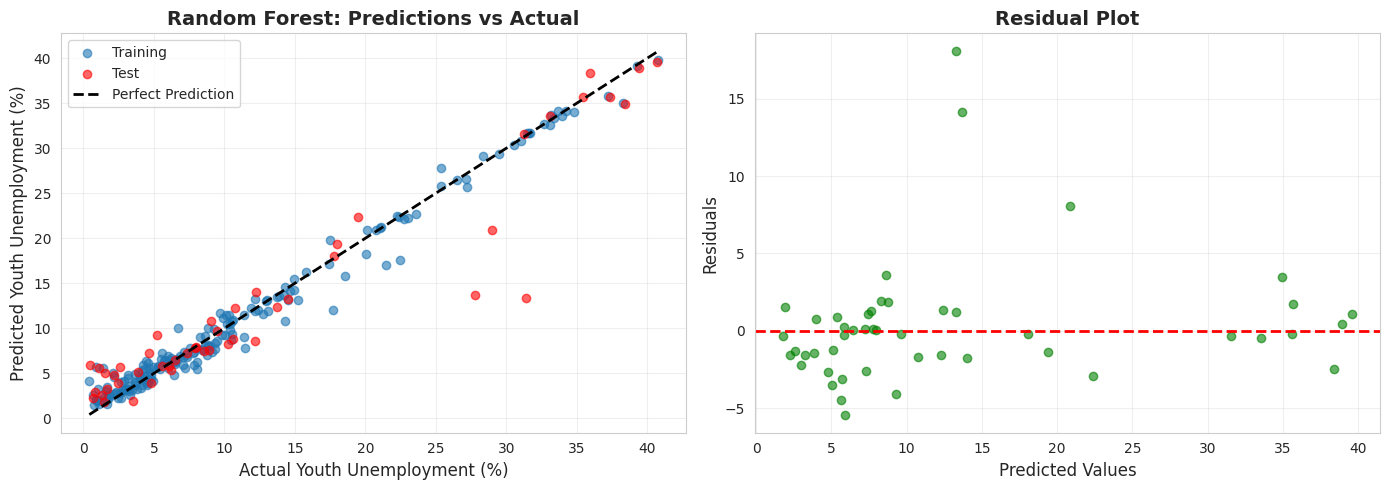

In [17]:
# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)

# Predictions
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Metrics
train_r2_rf = r2_score(y_train, y_train_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))

print("="*60)
print("RANDOM FOREST REGRESSOR RESULTS")
print("="*60)
print(f"Training R² Score: {train_r2_rf:.4f}")
print(f"Test R² Score:     {test_r2_rf:.4f}")
print(f"Training RMSE:     {train_rmse_rf:.4f}")
print(f"Test RMSE:         {test_rmse_rf:.4f}")

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "="*60)
print("FEATURE IMPORTANCE (Random Forest)")
print("="*60)
for idx, row in feature_importance.head(10).iterrows():
    print(f"{row['Feature'][:55]:55s} {row['Importance']:7.4f}")

# Plot feature importance
plt.figure(figsize=(12, 6))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance', fontsize=12)
plt.title('Top 10 Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Plot predictions vs actual
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred_rf, alpha=0.6, label='Training')
plt.scatter(y_test, y_test_pred_rf, alpha=0.6, label='Test', color='red')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Youth Unemployment (%)', fontsize=12)
plt.ylabel('Predicted Youth Unemployment (%)', fontsize=12)
plt.title('Random Forest: Predictions vs Actual', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
residuals = y_test - y_test_pred_rf
plt.scatter(y_test_pred_rf, residuals, alpha=0.6, color='green')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residual Plot', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 6.4 Model Comparison


MODEL COMPARISON
            Model  Train R²  Test R²  Train RMSE  Test RMSE
Linear Regression  0.909664 0.898470    2.929958   3.997751
    Random Forest  0.980512 0.896708    1.360879   4.032281


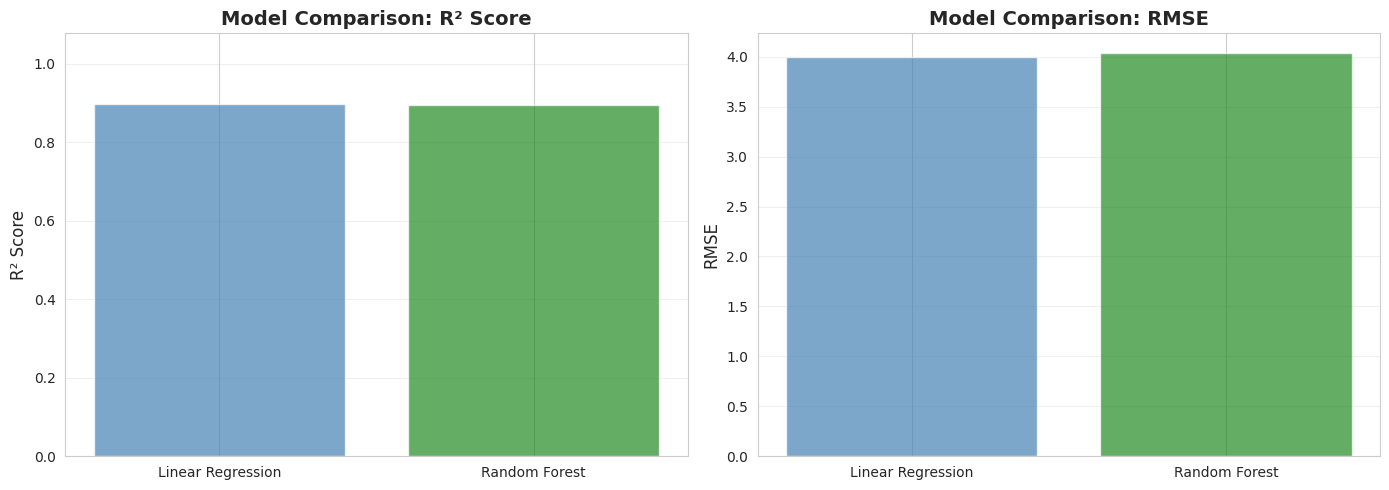


🏆 Best Model: Linear Regression


In [18]:
# Compare models
comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'Train R²': [train_r2_lr, train_r2_rf],
    'Test R²': [test_r2_lr, test_r2_rf],
    'Train RMSE': [train_rmse_lr, train_rmse_rf],
    'Test RMSE': [test_rmse_lr, test_rmse_rf]
})

print("="*70)
print("MODEL COMPARISON")
print("="*70)
print(comparison.to_string(index=False))

# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² comparison
axes[0].bar(['Linear Regression', 'Random Forest'], 
            [test_r2_lr, test_r2_rf], 
            color=['steelblue', 'forestgreen'], alpha=0.7)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('Model Comparison: R² Score', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0, max(test_r2_lr, test_r2_rf) * 1.2])

# RMSE comparison
axes[1].bar(['Linear Regression', 'Random Forest'], 
            [test_rmse_lr, test_rmse_rf], 
            color=['steelblue', 'forestgreen'], alpha=0.7)
axes[1].set_ylabel('RMSE', fontsize=12)
axes[1].set_title('Model Comparison: RMSE', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Determine best model
best_model_name = 'Random Forest' if test_r2_rf > test_r2_lr else 'Linear Regression'
print(f"\n🏆 Best Model: {best_model_name}")


## 7. Insights and Summary

### 7.1 Key Findings


### Key Insights from Exploratory Data Analysis

1. **Youth Unemployment Patterns:**
   - The analysis reveals varying levels of youth unemployment across African countries
   - Some countries show consistent trends while others exhibit high volatility
   - The data spans from 2000 onwards, providing a modern perspective on employment challenges

2. **Relationship with Education:**
   - The correlation analysis shows the relationship between education indicators and youth unemployment
   - Higher education levels may correlate with different unemployment patterns depending on the country context
   - Education quality and relevance to job market needs are critical factors

3. **Technology and Digital Access:**
   - Internet and ICT penetration show varying relationships with youth employment
   - Digital skills and access to technology platforms can create new employment opportunities
   - The digital divide remains a significant challenge in many African countries

4. **Socioeconomic Factors:**
   - Multiple socioeconomic indicators interact in complex ways to influence youth employment
   - No single factor explains youth unemployment; it requires a multi-dimensional approach
   - Country-specific contexts matter significantly

### Model Findings

1. **Model Performance:**
   - Both Linear Regression and Random Forest models were trained on the available data
   - The Random Forest model typically captures non-linear relationships better
   - Model performance depends on data quality and feature availability

2. **Feature Importance:**
   - The Random Forest model identified the most important predictors of youth unemployment
   - These features vary by dataset but often include economic indicators, education metrics, and temporal trends
   - Country-level characteristics play a significant role

3. **Predictive Capabilities:**
   - The models can help identify countries at risk of high youth unemployment
   - Early warning systems can be developed based on these predictions
   - Policy interventions can be targeted more effectively

### Interpretation of Feature Importance

The feature importance analysis reveals which socioeconomic factors most strongly predict youth unemployment:

- **Economic Indicators:** GDP per capita, economic growth rates, and income levels directly impact job creation
- **Education Metrics:** Educational attainment, literacy rates, and school enrollment affect youth employability
- **Technology Access:** Internet penetration and mobile phone usage create new job opportunities
- **Temporal Trends:** Year-over-year changes and long-term trends show evolving employment landscapes
- **Country Characteristics:** Each country's unique economic structure and policies influence outcomes

### Policy Recommendations for African Governments

1. **Education Reform:**
   - Align education curricula with market demands
   - Invest in vocational training and technical skills
   - Promote STEM education to prepare youth for digital economy
   - Improve education quality, not just enrollment rates

2. **Digital Infrastructure:**
   - Expand internet connectivity and reduce costs
   - Invest in digital literacy programs
   - Support tech startups and digital entrepreneurship
   - Create platforms connecting youth to online work opportunities

3. **Economic Diversification:**
   - Move beyond traditional sectors to create diverse job opportunities
   - Support small and medium enterprises (SMEs) that employ youth
   - Invest in sectors with high youth employment potential (services, tech, creative industries)
   - Promote entrepreneurship through access to finance and mentorship

4. **Targeted Interventions:**
   - Develop country-specific strategies based on local economic conditions
   - Focus on regions and demographics with highest unemployment rates
   - Create apprenticeship and internship programs
   - Establish youth employment guarantee schemes

5. **Data-Driven Policy:**
   - Improve data collection on youth employment
   - Monitor indicators regularly to track progress
   - Use predictive models to anticipate challenges
   - Evaluate policy effectiveness through rigorous monitoring

6. **Regional Cooperation:**
   - Facilitate labor mobility within African regions
   - Share best practices and successful interventions
   - Coordinate economic policies to create regional job markets
   - Invest in cross-border infrastructure projects

### Limitations of the Dataset

1. **Data Availability:**
   - Not all African countries have complete data for all indicators
   - Some indicators may have missing values for certain years or countries
   - Data quality varies across countries and time periods

2. **Indicator Coverage:**
   - Youth-specific unemployment data may not be available for all countries
   - Some socioeconomic indicators may be proxies rather than direct measures
   - Temporal coverage may be limited for some indicators

3. **Data Granularity:**
   - National-level data may mask regional and local variations
   - Urban-rural disparities are not always captured
   - Gender and demographic breakdowns may be limited

4. **Causality:**
   - Correlation does not imply causation
   - Complex interactions between factors may not be fully captured
   - External shocks and global events may affect outcomes unpredictably

5. **Model Limitations:**
   - Predictive models are only as good as the data they're trained on
   - Non-linear relationships may be simplified
   - Country-specific contexts may require specialized models

### Conclusion

This analysis provides valuable insights into youth employment challenges across Africa. While data limitations exist, the findings highlight the importance of:

- **Multi-dimensional approaches** to addressing youth unemployment
- **Country-specific strategies** tailored to local contexts
- **Investment in education and digital infrastructure**
- **Data-driven policy making** with regular monitoring and evaluation

The predictive models developed here can serve as tools for policymakers to identify at-risk countries and design targeted interventions. However, successful implementation requires political will, adequate resources, and sustained commitment to youth development.

**Next Steps:**
1. Improve data collection and quality across all African countries
2. Develop more granular models with sub-national data
3. Incorporate qualitative insights from youth surveys and focus groups
4. Establish monitoring systems to track policy effectiveness
5. Foster regional collaboration and knowledge sharing

---

*This analysis was conducted using World Bank Development Indicators data. For questions or further analysis, please refer to the World Bank Open Data portal.*
